<a href="https://colab.research.google.com/github/AchrafAsh/gnn-receptive-fields/blob/main/02_benchmark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Measuring over-smoothing on benchmark GNNs**
In this notebook I try to replicate the result from https://arxiv.org/pdf/1909.03211.pdf where they quantify over-smoothing thanks to the MAD metric.

In figure 2, they present how MAD evolves on several GNN with several layers.
The values are obtained by considering all node pairs (i.e all coefficients of the mask are set to 1, and all node indices are considered).
> we use the hidden representation of
the final layer of GNN. Term h is the hidden size

![](https://d3i71xaburhd42.cloudfront.net/a58995a12aca72e134e5271a412d178c576d56fd/3-Figure2-1.png)

## **Setup environment**

In [ ]:
# setup colab environment
import os, sys
import os.path as osp
from google.colab import drive
drive.mount('/content/mnt')
nb_path = '/content/notebooks'
try:
    os.symlink('/content/mnt/My Drive/Colab Notebooks', nb_path)
except:
    pass
sys.path.insert(0, nb_path)  # or append(nb_path)

Mounted at /content/mnt


### Load Cora dataset

In [ ]:
%%capture
!wget https://raw.githubusercontent.com/AchrafAsh/gnn-receptive-fields/main/data.py

In [ ]:
%%capture
from data import load_dataset

path = osp.join(os.getcwd(), 'data')
cora_dataset = load_dataset(path, 'Cora')
G = cora_dataset[0] # only graph of the dataset

## **Utility functions**

In [ ]:
import numpy as np

import torch
import torch.nn.functional as F

import seaborn as sns
import matplotlib.pyplot as plt

from typing import Tuple, Dict, List
from torch_geometric.utils import to_dense_adj
from tqdm import tqdm

%matplotlib inline

In [ ]:
# Official implementation
# https://github.com/victorchen96/MadGap/blob/master/madgap.py

import torch
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import pairwise_distances

#releated paper:(AAAI2020) Measuring and Relieving the Over-smoothing Problem for Graph Neural Networks from the Topological View.
#https://aaai.org/ojs/index.php/AAAI/article/view/5747

def mad_value(in_arr, mask_arr, distance_metric='cosine', digt_num=4, target_idx=None):
    """The numpy version for mad (able to compute quickly)

    Args:
        - in_arr [node_num, hidden_dim]: the node feature matrix
        - mask_arr [node_num, node_num]: the mask matrix of the target relations (is it the adjacency matrix?)
        - target_idx [1, 2, 3, ...n]: the nodes indices for which we calculate the mad value
    """
    dist_arr = pairwise_distances(in_arr, in_arr, metric=distance_metric)

    mask_dist = np.multiply(dist_arr,mask_arr)

    divide_arr = (mask_dist != 0).sum(1) + 1e-8

    node_dist = mask_dist.sum(1) / divide_arr

    if target_idx==None:
        mad = np.mean(node_dist)
    else:
        node_dist = np.multiply(node_dist,target_idx)
        mad = node_dist.sum()/((node_dist!=0).sum()+1e-8)

    mad = round(mad, digt_num)

    return mad

def mad_gap_regularizer(intensor,neb_mask,rmt_mask,target_idx):
    """The tensor version for mad_gap (Be able to transfer gradients)

    Args:
        - intensor [node_num, hidden_dim]: the node feature matrix
        - neb_mask, rmt_mask [node_num, node_num]: the mask matrices of the neighbor and remote relation
        - target_idx [1, 2, 3, ..., n]: the nodes indices for which we calculate the mad_gap value
    """

    node_num,feat_num = intensor.size()

    input1 = intensor.expand(node_num,node_num,feat_num)
    input2 = input1.transpose(0,1)

    input1 = input1.contiguous().view(-1,feat_num)
    input2 = input2.contiguous().view(-1,feat_num)

    simi_tensor = F.cosine_similarity(input1,input2, dim=1, eps=1e-8).view(node_num,node_num)
    dist_tensor = 1 - simi_tensor

    neb_dist = torch.mul(dist_tensor,neb_mask)
    rmt_dist = torch.mul(dist_tensor,rmt_mask)

    divide_neb = (neb_dist!=0).sum(1).type(torch.FloatTensor).cuda() + 1e-8
    divide_rmt = (rmt_dist!=0).sum(1).type(torch.FloatTensor).cuda() + 1e-8

    neb_mean_list = neb_dist.sum(1) / divide_neb
    rmt_mean_list = rmt_dist.sum(1) / divide_rmt

    neb_mad = torch.mean(neb_mean_list[target_idx])
    rmt_mad = torch.mean(rmt_mean_list[target_idx])

    mad_gap = rmt_mad - neb_mad

    return mad_gap

In [ ]:
mad_value(in_arr=G.x, mask_arr=np.ones((G.num_nodes, G.num_nodes)))

0.9441

In [ ]:
def mean_average_distance(x, target_idx=None, mask=None) -> float:
    # cosine similarity
    prod = torch.matmul(x, torch.transpose(x, 0, 1))
    x_norm = torch.norm(x, dim=0, keepdim=True)
    norm = torch.matmul(
        x_norm,
        torch.transpose(x_norm, 0, 1)
    )
    dist = 1 - torch.div(prod, norm)

    # filter with mask
    if mask is not None:
        dist = dist * mask
    
    # average distance along rows
    mean_dist = torch.div(
        torch.sum(dist, dim=1, keepdim=True),
        torch.sum(dist != 0, dim=1, keepdim=True) + 1e-8
    )

    if target_idx is not None:
        return torch.mean(mean_dist.view(-1)[target_idx])

    # final average
    return torch.sum(mean_dist) / (torch.sum(mean_dist != 0) + 1e-8)

In [ ]:
mean_average_distance(G.x)

tensor(1.0000)

In [ ]:
def count_parameters(model: torch.nn.Module):
    print(f"The model has {sum(p.numel() for p in model.parameters() if p.requires_grad):,} parameters")

In [ ]:
def train(model: torch.nn.Module, optimizer: torch.optim.Optimizer,
          data: type(G), edge_index) -> Tuple[torch.tensor, float]:
    
    model.train()
    optimizer.zero_grad()

    hidden_state, out = model(data.x, edge_index)
    
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return hidden_state, loss

In [ ]:
def evaluate(model: torch.nn.Module, data: type(G), edge_index) -> Dict[str, float]:
    model.eval()

    with torch.no_grad():
        h, logits = model(data.x, edge_index)
    
    outs = {}
    mad = mad_value(in_arr=h.detach().numpy(), 
                    mask_arr=np.ones((data.num_nodes, data.num_nodes)))
    outs["mad"] = mad
    for key in ['train', 'val', 'test']:
        mask = data[f'{key}_mask']
        loss = F.nll_loss(logits[mask], data.y[mask]).item()
        pred = logits[mask].max(1)[1]
        acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()

        outs[f'{key}_loss'] = loss
        outs[f'{key}_acc'] = acc
    return outs

In [ ]:
def run(data: type(G), model: torch.nn.Module,
        edge_index,
        runs: int, epochs: int, lr: float,
        weight_decay: float,
        early_stopping: int = 0,
        initialize:bool=True) -> Tuple[List[float], List[float], List[float]]:

    dense_adj = to_dense_adj(G.edge_index)
    val_losses, accs, durations = [], [], []
    for _ in range(runs):
        data = data.to(device)
        model.to(device)
        if initialize:
            model.reset_parameters()
        
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, 
                                     weight_decay=weight_decay)

        if torch.cuda.is_available():
            torch.cuda.synchronize()
        
        t_start = time.perf_counter()

        best_val_loss = float('inf')
        val_loss_history, train_losses, test_accs, MADs = [], [], [], []

        for epoch in range(1, epochs+1):
            hidden_state, train_loss = train(model, optimizer, data, edge_index)

            eval_info = evaluate(model, data, edge_index)
            
            test_acc = eval_info['test_acc']
            val_loss_history.append(eval_info['val_loss'])
            train_losses.append(train_loss.item())
            test_accs.append(test_acc)
            MADs.append(eval_info["mad"])
        
            # I don't understand what this is for...
            if eval_info['val_loss'] < best_val_loss:
                best_val_loss = eval_info['val_loss']
            
            if early_stopping > 0 and epoch > epochs // 2:
                tmp = torch.tensor(val_loss_history[-(early_stopping + 1):-1])
                if eval_info['val_loss'] > tmp.mean().item():
                    break
            
            if epoch % 10 == 0:
                print(f"Epoch: [{epoch} / {epochs}] | Loss: {train_loss} | Test accuracy: {test_acc} | MAD: {eval_info['mad']}")

        if torch.cuda.is_available():
            torch.cuda.synchronize()

        t_end = time.perf_counter()

        val_losses.append(best_val_loss)
        accs.append(test_acc)
        durations.append(t_end - t_start)

    loss, acc, duration = torch.tensor(val_losses), torch.tensor(accs), torch.tensor(durations)

    print(f"Val Loss: {loss.mean().item():.4f}, Test Accuracy: {acc.mean().item():.3f} ± {acc.std().item():.3f}, Duration: {duration.mean().item():.3f}")
    return train_losses, test_accs, MADs

In [ ]:
import time

## **Vanilla GCN**

In [ ]:
from torch_geometric.nn import Sequential, GCNConv, GATConv

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
class VanillaGCN(torch.nn.Module):
    def __init__(self, num_layers:int, hidden_dim:int, num_features:int, num_classes:int, dropout:float=0.5):
        super().__init__()
        self.conv_layers = self.create_layers(num_layers=num_layers, 
                                              num_features=num_features,
                                              num_classes=num_classes,
                                              hidden_dim=hidden_dim,
                                              dropout=dropout)
        self.out_gcn = GCNConv(in_channels=hidden_dim, out_channels=num_classes)
        self.relu = torch.nn.ReLU()
        self.dropout = torch.nn.Dropout(p=dropout)
        self.log_softmax = torch.nn.LogSoftmax(dim=1)


    def create_layers(self, num_layers:int, num_features:int, num_classes:int, 
                      hidden_dim:int, dropout:float):
        if num_layers == 2:
            return Sequential("x, edge_index", [(GCNConv(in_channels=num_features, out_channels=hidden_dim), "x, edge_index -> x")])

        layers = []

        # first layer
        layers += [
                (GCNConv(in_channels=num_features, out_channels=hidden_dim), "x, edge_index -> x"),
                (torch.nn.ReLU(), "x -> x"),
                (torch.nn.Dropout(p=dropout), "x -> x")
        ]

        for k in range(1, num_layers-2):
            layers += [
                (GCNConv(in_channels=hidden_dim, out_channels=hidden_dim), "x, edge_index -> x"),
                (torch.nn.ReLU(), "x -> x"),
                (torch.nn.Dropout(p=dropout), "x -> x")
            ]
        
        # last layer
        layers += [
            (GCNConv(in_channels=hidden_dim, out_channels=hidden_dim), "x, edge_index -> x")
        ]
        return Sequential("x, edge_index", layers)


    def reset_parameters(self):
        self.conv_layers.reset_parameters()
        # self.out_gcn.reset_parameters()


    def forward(self, x, edge_index):
        h = self.conv_layers(x, edge_index)
        out = self.relu(h)
        out = self.dropout(out)
        out = self.out_gcn(out, edge_index)
        
        return h, self.log_softmax(out)

### Experiments

In [ ]:
NUM_LAYERS=15
HIDDEN_DIM=16
NUM_FEATURES=cora_dataset.num_features
NUM_CLASSES=cora_dataset.num_classes
EPOCHS=1000
LR=0.01
WEIGHT_DECAY=5e-4
EARLY_STOPPING=0
RUNS=1

In [ ]:
model = VanillaGCN(num_layers=NUM_LAYERS, hidden_dim=HIDDEN_DIM, num_features=NUM_FEATURES, num_classes=NUM_CLASSES)
count_parameters(model)

The model has 26,599 parameters


In [ ]:
train_loss, test_acc, mads = run(data=G, model=model,
    edge_index=G.edge_index,
    runs=RUNS, epochs=EPOCHS,
    lr=LR,
    weight_decay=WEIGHT_DECAY,
    early_stopping=EARLY_STOPPING)

Epoch: [10 / 1000] | Loss: 1.9382555484771729 | Test accuracy: 0.14 | MAD: 0.0132
Epoch: [20 / 1000] | Loss: 1.7435634136199951 | Test accuracy: 0.228 | MAD: 0.3517
Epoch: [30 / 1000] | Loss: 1.625108242034912 | Test accuracy: 0.259 | MAD: 0.3359
Epoch: [40 / 1000] | Loss: 1.559754490852356 | Test accuracy: 0.287 | MAD: 0.3988
Epoch: [50 / 1000] | Loss: 1.524748682975769 | Test accuracy: 0.356 | MAD: 0.4534
Epoch: [60 / 1000] | Loss: 1.4615392684936523 | Test accuracy: 0.389 | MAD: 0.4738
Epoch: [70 / 1000] | Loss: 1.4334112405776978 | Test accuracy: 0.311 | MAD: 0.5069
Epoch: [80 / 1000] | Loss: 1.3535611629486084 | Test accuracy: 0.307 | MAD: 0.4977
Epoch: [90 / 1000] | Loss: 1.4817428588867188 | Test accuracy: 0.273 | MAD: 0.533
Epoch: [100 / 1000] | Loss: 1.3473551273345947 | Test accuracy: 0.381 | MAD: 0.5013
Epoch: [110 / 1000] | Loss: 1.3065476417541504 | Test accuracy: 0.354 | MAD: 0.4985
Epoch: [120 / 1000] | Loss: 1.3797165155410767 | Test accuracy: 0.316 | MAD: 0.5207
Epoch:

Number of layers: 15


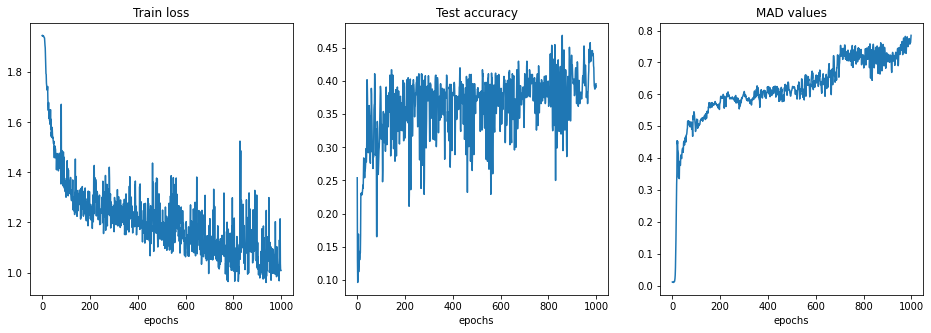

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(16, 5))

sns.lineplot(x=range(EPOCHS), y=train_loss, ax=ax[0]).set(title="Train loss", xlabel="epochs")
sns.lineplot(x=range(EPOCHS), y=test_acc, ax=ax[1]).set(title="Test accuracy", xlabel="epochs")
sns.lineplot(x=range(EPOCHS), y=mads, ax=ax[2]).set(title="MAD values", xlabel="epochs")

fig.show()
print(f"Number of layers: {NUM_LAYERS}")

In [ ]:
model??

### Evolution over layers

In [ ]:
# all_acc, mads = [], []

for K in range(16, 19):
    model = VanillaGCN(num_layers=K, hidden_dim=HIDDEN_DIM, num_features=NUM_FEATURES, num_classes=NUM_CLASSES)

    _, _, _ = run(data=G, model=model,
               edge_index=G.edge_index,
               runs=RUNS, epochs=EPOCHS,
               lr=LR,
               weight_decay=WEIGHT_DECAY,
               early_stopping=EARLY_STOPPING)
    
    eval_info = evaluate(model=model, data=G, edge_index=G.edge_index)

    all_acc.append(eval_info["test_acc"])
    mads.append(eval_info["mad"])

Epoch: [360 / 400] | Loss: 1.9138259887695312 | Test accuracy: 0.142 | MAD: 0.0474
Epoch: [370 / 400] | Loss: 1.8645703792572021 | Test accuracy: 0.139 | MAD: 0.0464
Epoch: [380 / 400] | Loss: 1.8871638774871826 | Test accuracy: 0.144 | MAD: 0.0332
Epoch: [390 / 400] | Loss: 1.8711332082748413 | Test accuracy: 0.146 | MAD: 0.0373
Epoch: [400 / 400] | Loss: 1.863556146621704 | Test accuracy: 0.141 | MAD: 0.0437
Val Loss: 1.8948, Test Accuracy: 0.141 ± nan, Duration: 109.197


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


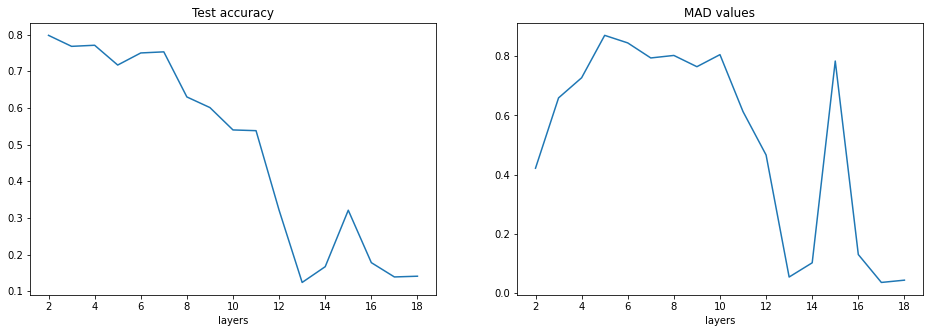

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(16, 5))

sns.lineplot(range(2, 19), all_acc, ax=ax[0]).set(title="Test accuracy", xlabel="layers")
sns.lineplot(range(2, 19), mads, ax=ax[1]).set(title="MAD values", xlabel="layers")

fig.show()